In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('MNIST_data')
input_size = 784
num_digits = 10

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
params = {
    'e_layers': [128],
    'd_layers': [128],
    'digit_layers': [128],
    'd_std': 0.3,
    'z_dim': 10,
    'activation': tf.nn.sigmoid,
    'batch_size': 100,
    'epochs': 20,
    'learning_rate': 0.0005,
    'digit_classifier_weight': 1
}

In [4]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z, layer, activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


def digit_classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=params['activation'])
    logits = tf.layers.dense(x, num_digits)
    return logits

In [5]:
images = tf.placeholder(tf.float32, [None, input_size])
digits = tf.placeholder(tf.int32, [None])
e_mu, e_var = encoder(images, params['e_layers'])
eps = tf.random_normal([tf.shape(images)[0], params['z_dim']], mean=0.0, stddev=1.0)
z = e_mu + tf.sqrt(e_var) * eps
digit_logits = digit_classifier(images, params['digit_layers'])
digit_prob = tf.nn.softmax(digit_logits)
d_mu = decoder(tf.concat([z, digit_prob], axis=1), params['d_layers'])

In [6]:
loss_encode = -0.5 * tf.reduce_sum(1 + tf.log(e_var) - e_mu ** 2 - e_var, axis=1)
loss_decode = -tf.reduce_sum(tf.contrib.distributions.Normal(d_mu, params['d_std']).log_prob(images), axis=1)
loss_digit_classifier = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=digits, logits=digit_logits)
loss = tf.reduce_mean(loss_encode +
                      loss_decode +
                      params['digit_classifier_weight'] * loss_digit_classifier, axis=0)

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

In [7]:
samples = []
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(params['epochs']):
        for _ in range(mnist.train.num_examples / params['batch_size']):
            batch_images, batch_digits = mnist.train.next_batch(params['batch_size'])
            sess.run(train_op, feed_dict={images: batch_images, digits: batch_digits})
        
        train_loss = sess.run(loss, {images: mnist.train.images, digits: mnist.train.labels})
            
        print "Epoch {}/{}...".format(epoch + 1, params['epochs']), "Loss: {:.4f}".format(train_loss)
        # Save losses to view after training
        losses.append(train_loss)
        
        # Sample an image as we're training for viewing afterwards
        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_digits, 1])
        gen_samples = sess.run(d_mu, feed_dict={z: sample_z, digit_prob: np.eye(num_digits)})
        samples.append(gen_samples)

Epoch 1/20... Loss: 27.8503
Epoch 2/20... Loss: -25.5652
Epoch 3/20... Loss: -46.3405
Epoch 4/20... Loss: -60.1006
Epoch 5/20... Loss: -70.2145
Epoch 6/20... Loss: -77.7620
Epoch 7/20... Loss: -83.2011
Epoch 8/20... Loss: -87.8390
Epoch 9/20... Loss: -91.9477
Epoch 10/20... Loss: -96.1305
Epoch 11/20... Loss: -99.6092
Epoch 12/20... Loss: -102.8553
Epoch 13/20... Loss: -105.3685
Epoch 14/20... Loss: -108.1041
Epoch 15/20... Loss: -110.4965
Epoch 16/20... Loss: -112.7233
Epoch 17/20... Loss: -114.6636
Epoch 18/20... Loss: -116.4163
Epoch 19/20... Loss: -118.0912
Epoch 20/20... Loss: -119.7011


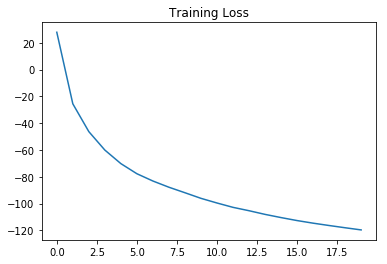

In [8]:
plt.plot(losses)
plt.title('Training Loss')

In [15]:
def plot_samples(samples, fig_width=7):
    plt.figure(figsize=(fig_width, len(samples) * fig_width))
    samples = np.concatenate(samples)
    for i in xrange(len(samples)):
        plt.subplot(len(samples), num_digits, i + 1)
        plt.imshow(samples[i].reshape((28, 28)), cmap='Greys_r')
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False)

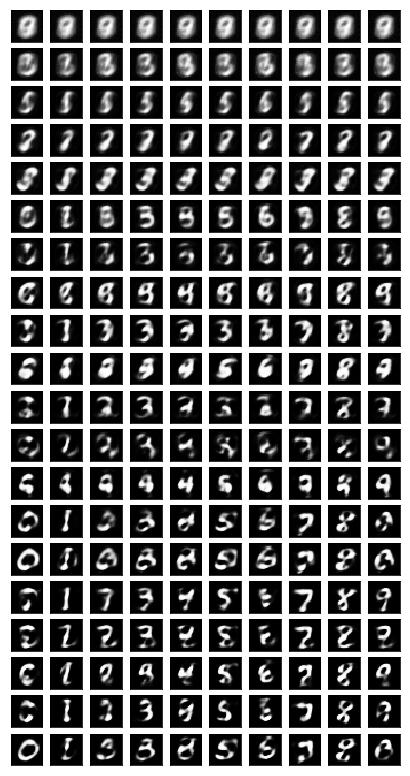

In [16]:
plot_samples(samples)